<a href="https://colab.research.google.com/github/adalbertii/Modele-klasyfikacyjne/blob/main/keras_classification_case.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Klasyfikacja binarna**

Oparta na modelu neuronowym

Rozpoznawanie cukrzycy

Step 1 - Loading the Required Libraries and Modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import classification_report

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

In [8]:
import warnings
warnings.filterwarnings('ignore')

**Pobranie danych i ich uproszczona analiza**

In [2]:
# zamontować dysk Google
df = pd.read_csv('/content/drive/MyDrive/dane/diabetes.csv')
print(df.shape)

(768, 9)


In [3]:

df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
# analiza statystyczna zbioru danych
df.describe()

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


In [6]:
# sprawdzamy korelacje zmiennych
df.corr()['Outcome'].sort_values(ascending=False)

Outcome                     1.000000
Glucose                     0.466581
BMI                         0.292695
Age                         0.238356
Pregnancies                 0.221898
DiabetesPedigreeFunction    0.173844
Insulin                     0.130548
SkinThickness               0.074752
BloodPressure               0.065068
Name: Outcome, dtype: float64

                                  Matryca korelacji zmiennych                                   


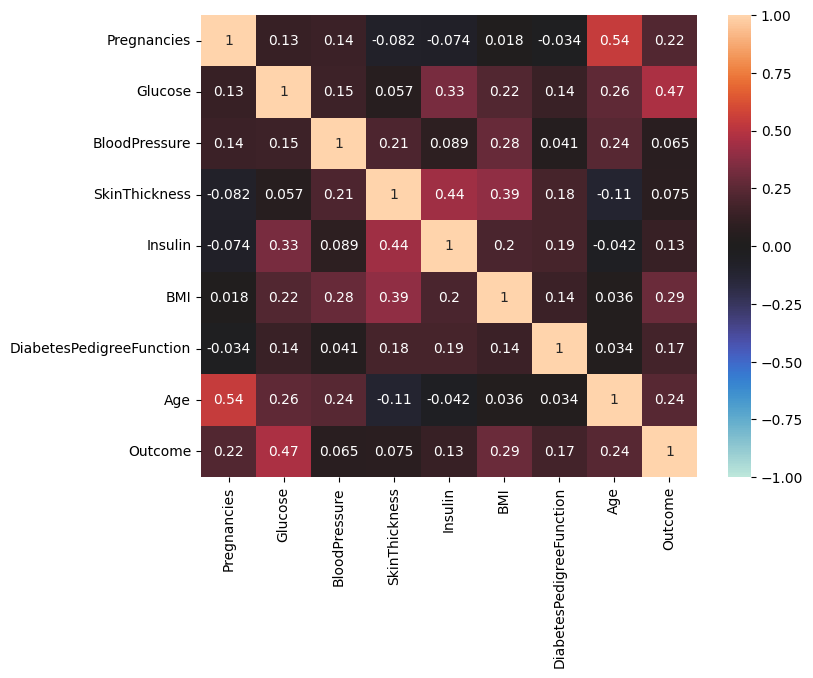

In [7]:
#Sprawdzenie korelacji

print('\033[1mMatryca korelacji zmiennych'.center(100))
plt.figure(figsize=[8,6])
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, center=0) #cmap='BuGn'
plt.show()

In [30]:
#sprawdzenie rozkładu unikalnych wartości zmiennej objaśnianej
print(np.unique(df['Outcome'], return_counts=True))

(array([0, 1]), array([500, 268]))


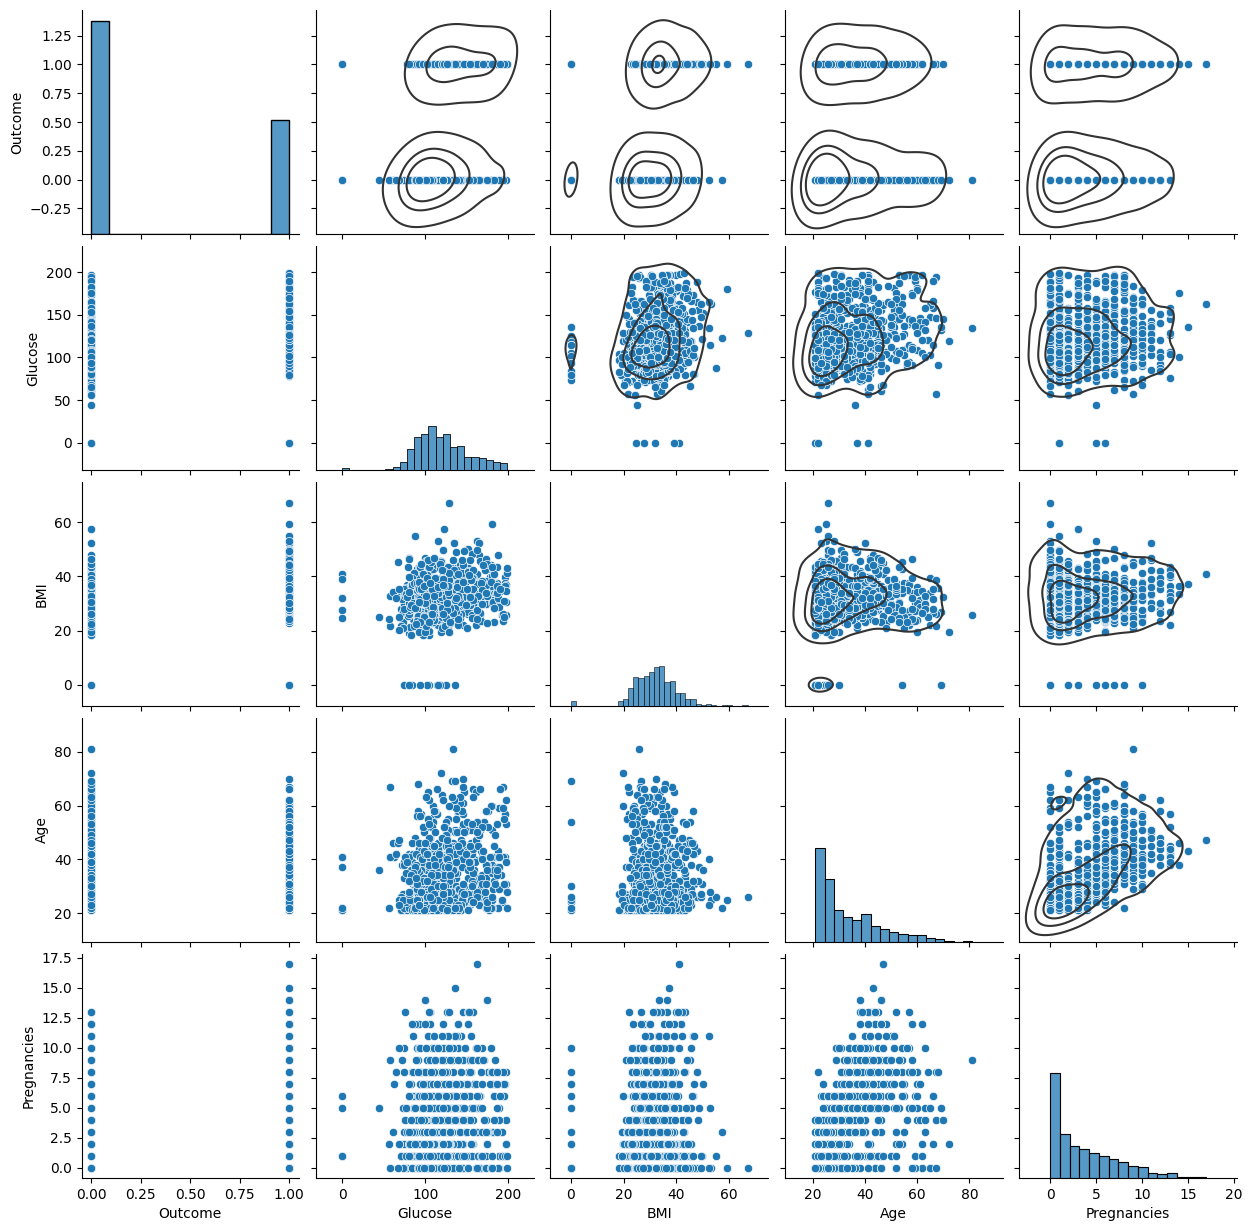

In [10]:
#weryfikacja zależności pomiedzy zmiennymi

g = sns.pairplot(df[['Outcome', 'Glucose', 'BMI', 'Age','Pregnancies']])
#plt.title('Wykresy par dla wszystkich zmiennych')
g.map_upper(sns.kdeplot, levels=4, color=".2")
plt.show()

Step 3 - Creating Arrays for the Features and the Response Variable.

In [11]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [12]:
target_column = ['Outcome']
predictors = list(set(list(df.columns))-set(target_column))
predictors

['Age',
 'BloodPressure',
 'BMI',
 'DiabetesPedigreeFunction',
 'Glucose',
 'SkinThickness',
 'Insulin',
 'Pregnancies']

In [13]:
# uproszczone skalowanie wartości
df[predictors] = df[predictors]/df[predictors].max()
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,0.226180,0.607510,0.566438,0.207439,0.094326,0.476790,0.194990,0.410381,0.348958
std,0.198210,0.160666,0.158654,0.161134,0.136222,0.117499,0.136913,0.145188,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.032231,0.259259,0.000000
25%,0.058824,0.497487,0.508197,0.000000,0.000000,0.406855,0.100723,0.296296,0.000000
50%,0.176471,0.587940,0.590164,0.232323,0.036052,0.476900,0.153926,0.358025,0.000000
75%,0.352941,0.704774,0.655738,0.323232,0.150414,0.545455,0.258781,0.506173,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [14]:
# tworzy tablice np.array
X = df[predictors].values
y = df[target_column].values

In [15]:
X.shape

(768, 8)

In [16]:
y.shape

(768, 1)

In [17]:
# podzial zbioru na dane treningowe i testowe
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=40)
print('X_train:', X_train.shape); print('X_test:', X_test.shape);print('y_train:', y_train.shape);print('y_test:',y_test.shape)

X_train: (537, 8)
X_test: (231, 8)
y_train: (537, 1)
Y_test: (231, 1)


In [18]:
#Ponieważ nasza zmienna docelowa reprezentuje kategorię binarną, która została zakodowana jako liczby 0 i 1,
#będziemy musieli ją zakodować.
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

count_classes = y_test.shape[1]
print('Liczba klas:', count_classes)

Liczba klas: 2


In [19]:
y_train[:5]

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [20]:
print(y_train.shape)
y_train

(537, 2)


array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

**Definicja, kompilacja i uczenie modelu neuronowego**

In [21]:
X_train.shape

(537, 8)

In [22]:
#definicja modelu
model = Sequential()
model.add(Dense(500, activation='relu', input_dim=8)) # objaśnić input_dim
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(2, activation='softmax'))# objaśnić funkcje aktywacji softmax


# Podczas pracy nad problemem uczenia maszynowego lub głębokiego uczenia,
# funkcje strat/kosztów są wykorzystywane do optymalizacji modelu podczas szkolenia.
# Celem jest prawie zawsze zminimalizowanie funkcji strat.
# Im niższa strata, tym lepszy model. Cross-Entropy loss jest najważniejszą funkcją kosztu.
# Służy ona do optymalizacji modeli klasyfikacyjnych.

In [23]:
# kompilacja modelu
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 500)               4500      
                                                                 
 dense_1 (Dense)             (None, 100)               50100     
                                                                 
 dense_2 (Dense)             (None, 50)                5050      
                                                                 
 dense_3 (Dense)             (None, 2)                 102       
                                                                 
Total params: 59752 (233.41 KB)
Trainable params: 59752 (233.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
# uczenie modelu
model.fit(X_train, y_train, epochs=20, verbose=1)

Epoch 1/20
17/17 [==============================] - 1s 3ms/step - loss: 0.6597 - accuracy: 0.6555
Epoch 2/20
17/17 [==============================] - 0s 2ms/step - loss: 0.6252 - accuracy: 0.6667
Epoch 3/20
17/17 [==============================] - 0s 2ms/step - loss: 0.5966 - accuracy: 0.6946
Epoch 4/20
17/17 [==============================] - 0s 2ms/step - loss: 0.5727 - accuracy: 0.7002
Epoch 5/20
17/17 [==============================] - 0s 2ms/step - loss: 0.5385 - accuracy: 0.7244
Epoch 6/20
17/17 [==============================] - 0s 3ms/step - loss: 0.5166 - accuracy: 0.7505
Epoch 7/20
17/17 [==============================] - 0s 2ms/step - loss: 0.5047 - accuracy: 0.7449
Epoch 8/20
17/17 [==============================] - 0s 2ms/step - loss: 0.4914 - accuracy: 0.7616
Epoch 9/20
17/17 [==============================] - 0s 2ms/step - loss: 0.4849 - accuracy: 0.7654
Epoch 10/20
17/17 [==============================] - 0s 3ms/step - loss: 0.4617 - accuracy: 0.7896
Epoch 11/20
17/17 [

**Ewaluacja modelu**

In [25]:
pred_train= model.predict(X_train)
scores = model.evaluate(X_train, y_train, verbose=0)
print('Accuracy on training data: {}% \n Error on training data: {}'.format(scores[1], 1 - scores[1]))

pred_test= model.predict(X_test)
scores2 = model.evaluate(X_test, y_test, verbose=0)
print('Accuracy on test data: {}% \n Error on test data: {}'.format(scores2[1], 1 - scores2[1]))

17/17 [==============================] - 0s 1ms/step
Accuracy on training data: 0.7839850783348083% 
 Error on training data: 0.21601492166519165
8/8 [==============================] - 0s 2ms/step
Accuracy on test data: 0.7662337422370911% 
 Error on test data: 0.23376625776290894


In [26]:
y_pred=model.predict(X_test)
y_pred=(y_pred>0.5)

8/8 [==============================] - 0s 2ms/step


In [27]:
conf_test=confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

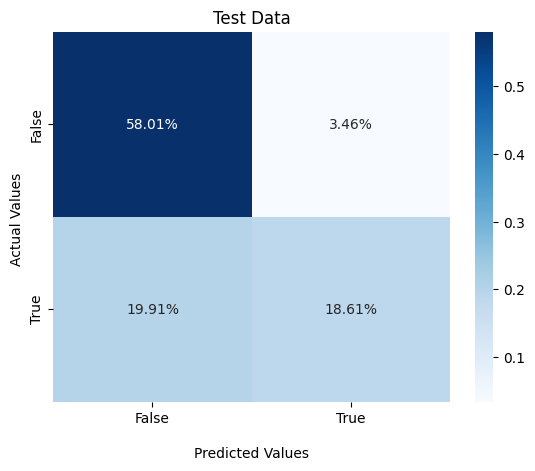

In [28]:
ax = sns.heatmap(conf_test/np.sum(conf_test), annot=True,
            fmt='.2%', cmap='Blues')

ax.set_title('Test Data');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

plt.show()

In [29]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.94      0.83       142
           1       0.84      0.48      0.61        89

   micro avg       0.77      0.77      0.77       231
   macro avg       0.79      0.71      0.72       231
weighted avg       0.78      0.77      0.75       231
 samples avg       0.77      0.77      0.77       231

